In [74]:
# Check GPU status in Colab
!nvidia-smi

Thu Feb 13 15:01:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             33W /   70W |    8566MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [75]:
# Import TensorFlow library
import tensorflow as tf

In [76]:
# Check TensorFlow version
tf.__version__

'2.18.0'

In [77]:
# Import Keras library
import keras as ks

In [78]:
# Check Keras version
ks.__version__

'3.8.0'

In [79]:
# Get the present working directory
%pwd

'/content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES'

In [80]:
# Change directory to the training dataset folder in Google Drive
%cd /content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES/Train

/content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES/Train


In [81]:
# List files and directories in the current directory
%ls

benign/  malignant/  normal/


In [82]:
# Import necessary layers from Keras
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten

# Import Model class from Keras to define models
from tensorflow.keras.models import Model

# Import VGG16 pre-trained model from Keras applications
from tensorflow.keras.applications.vgg16 import VGG16

# Import Keras preprocessing tools for image loading and image data augmentation
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Import Keras Sequential model class
from tensorflow.keras.models import Sequential

# Import NumPy for numerical operations
import numpy as np

# Import glob to search for files matching a specific pattern
from glob import glob

In [83]:
%ls

benign/  malignant/  normal/


In [84]:
%cd /content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES

/content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES


In [85]:
# Define the image size for input to the model
IMAGE_SIZE = [224, 224]

# Specify the directory paths for training and validation data
train_path = "Train"
validation_path = "Validations"

In [86]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# input_shape=IMAGE_SIZE + [3]: This specifies the input shape of the images (224x224x3, where 3 represents the RGB color channels).
# weights='imagenet': This loads the pre-trained weights from ImageNet.
# include_top=False: This excludes the fully connected layers at the top of the network, allowing you to use VGG16 as a feature extractor, which is common in transfer learning.

In [87]:
# Loop through each layer of the VGG16 model and print its details
for layer in vgg16.layers:
    print(layer)

<InputLayer name=input_layer_2, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<Conv2D name=block5_conv1, built=True>
<Conv2D name=block5_conv2, built=True>
<Conv2D name=block5_conv3, built=True>
<MaxPooling2D name=block5_pool, built=True>


In [88]:
# Freeze all layers of the VGG16 model to prevent training updates
for layer in vgg16.layers:
    layer.trainable = False

In [89]:
# Print the name and trainability status of each layer in VGG16
for layer in vgg16.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [90]:
# Print the summary of the VGG16 model, including layer types, output shapes, and parameters
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [91]:
# Get the present working directory
%pwd

'/content/drive/MyDrive/AI/Image_Classification/BUS_IMAGES'

In [92]:
# Get all the subdirectories (folders) in the 'Train' directory
train_folder = glob('Train/*')

# Get all the subdirectories (folders) in the 'Validations' directory
validation_folder = glob('Validations/*')

In [93]:
# Display the list of subdirectories (or files) in the 'Train' folder
print(train_folder)

['Train/normal', 'Train/malignant', 'Train/benign']


In [94]:
# Get the number of items (subdirectories or files) in the 'Train' folder
print(len(train_folder))

3


In [95]:
# Initialize a Sequential model
model = Sequential()

# Add the pre-trained VGG16 model as a base (feature extractor)
model.add(vgg16)

# Flatten the output of VGG16 to a 1D vector (necessary before adding fully connected layers)
model.add(Flatten())

# Add a fully connected dense layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Add the final output layer with softmax activation to classify based on the number of classes in the 'Train' folder
# model.add(Dense(3, activation='softmax'))  # This is commented out, but could be used for a fixed 3-class output
model.add(Dense(len(train_folder), activation='softmax'))

In [96]:
# Display the summary of the model, showing layer details, output shapes, and parameters
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [97]:
# Compile the model with the specified loss function, optimizer, and evaluation metrics
model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer='adam',  # Adam optimizer for efficient training
    metrics=['accuracy']  # Track accuracy as a metric during training
)

In [98]:
# Create an ImageDataGenerator for data augmentation and normalization
train_data_gen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to the range [0, 1]
    shear_range=0.2,  # Apply random shear transformations to the images
    zoom_range=0.2,   # Apply random zoom transformations to the images
    horizontal_flip=True  # Randomly flip images horizontally
)

In [99]:
# Create an ImageDataGenerator for testing/validation data normalization
test_data_gen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to the range [0, 1]
)

In [100]:
train_path = "Train"
training_set = train_data_gen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 720 images belonging to 3 classes.


In [101]:
# Load and preprocess validation data from the specified directory
test_path = "Validations"  # Path to the validation data directory
testing_set = test_data_gen.flow_from_directory(
    test_path,  # Directory containing the validation images
    target_size=(224, 224),  # Resize images to 224x224 to match VGG16 input size
    batch_size=32,  # Number of images to process in each batch
    class_mode='categorical'  # Multi-class classification (one-hot encoded labels)
)

Found 60 images belonging to 3 classes.


In [102]:
# Train the model using the training and validation datasets
history = model.fit(
    training_set,  # The training data generator
    validation_data=testing_set,  # The validation data generator
    epochs=10,  # Number of epochs to train the model
    steps_per_epoch=len(training_set),  # Number of batches per epoch (based on training data size)
    validation_steps=len(testing_set)  # Number of validation batches per epoch (based on testing data size)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 832ms/step - accuracy: 0.4253 - loss: 4.6115 - val_accuracy: 0.6833 - val_loss: 0.8463
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 716ms/step - accuracy: 0.6465 - loss: 0.8487 - val_accuracy: 0.6667 - val_loss: 0.8381
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 739ms/step - accuracy: 0.7318 - loss: 0.7068 - val_accuracy: 0.4833 - val_loss: 0.9735
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 740ms/step - accuracy: 0.7077 - loss: 0.6450 - val_accuracy: 0.5333 - val_loss: 0.8776
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 721ms/step - accuracy: 0.7394 - loss: 0.5947 - val_accuracy: 0.5167 - val_loss: 1.0893
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 750ms/step - accuracy: 0.7697 - loss: 0.5642 - val_accuracy: 0.6000 - val_loss: 0.8323
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - accuracy: 0.8003 - loss: 0.5016 - val_accuracy: 0.6667 - val_loss: 0.6572
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 709ms/step - accuracy: 0.8256 - loss: 0.4554 - val_accu

In [103]:
# Import matplotlib for data visualization
import matplotlib.pyplot as plt

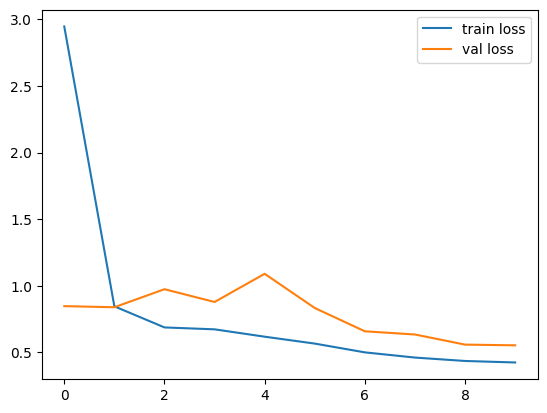

<Figure size 640x480 with 0 Axes>

In [104]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'], label="train loss")  # Plot training loss
plt.plot(history.history['val_loss'], label="val loss")  # Plot validation loss

# Add a legend to differentiate between train and validation loss
plt.legend()

# Display the plot
plt.show()

# Save the loss plot as a PNG image
plt.savefig("Loss Graph.png")

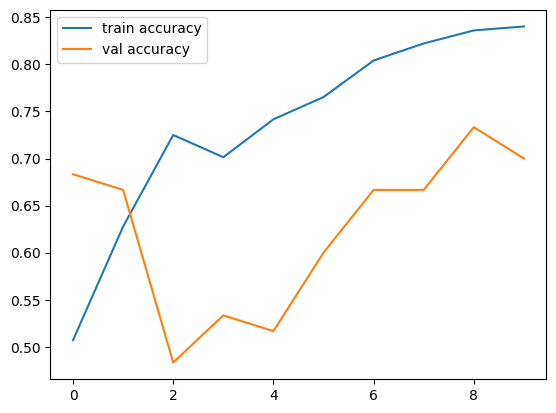

<Figure size 640x480 with 0 Axes>

In [105]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'], label="train accuracy")  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label="val accuracy")  # Plot validation accuracy

# Add a legend to differentiate between train and validation accuracy
plt.legend()

# Display the plot
plt.show()

# Save the accuracy plot as a PNG image
plt.savefig("Accuracy Graph.png")

In [106]:
# Save the trained model to a file in HDF5 format
model.save("model_vgg16_bc.h5")

In [107]:
# Import the function to load a previously saved Keras model
from tensorflow.keras.models import load_model

# Load the saved model from the file 'model_vgg16_bc.h5'
model = load_model("model_vgg16_bc.h5")

In [108]:
# Make predictions on the testing data using the trained model
y_pred = model.predict(testing_set)

# Display the predictions
y_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step


array([[6.73022449e-01, 6.14381842e-02, 2.65539378e-01],
       [4.23629284e-01, 6.12924807e-02, 5.15078247e-01],
       [2.38487571e-01, 7.54967928e-01, 6.54449733e-03],
       [3.34366024e-01, 4.81942622e-03, 6.60814583e-01],
       [7.24617839e-01, 1.69417605e-01, 1.05964556e-01],
       [9.96776402e-01, 2.43506394e-03, 7.88464618e-04],
       [3.83098960e-01, 6.43259333e-03, 6.10468447e-01],
       [3.96211326e-01, 5.71042240e-01, 3.27464677e-02],
       [3.61220539e-01, 5.34501016e-01, 1.04278356e-01],
       [9.57089186e-01, 2.06957217e-02, 2.22151075e-02],
       [1.90090761e-01, 3.29609611e-03, 8.06613147e-01],
       [4.30682659e-01, 4.96765882e-01, 7.25514889e-02],
       [2.94459403e-01, 6.95136130e-01, 1.04045039e-02],
       [5.97900748e-01, 3.26590329e-01, 7.55088478e-02],
       [4.68249112e-01, 4.77146626e-01, 5.46043329e-02],
       [1.70234054e-01, 7.77336769e-03, 8.21992636e-01],
       [9.81835842e-01, 4.36360203e-03, 1.38004776e-02],
       [9.25965548e-01, 8.49623

In [109]:
# Convert the predicted class probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Display the predicted class labels
y_pred

array([0, 2, 1, 2, 0, 0, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 0])

In [110]:
# List the files and directories in the current working directory
%ls

'Accuracy Graph.png'  'Loss Graph.png'   model_vgg16_bc.h5   test.png   Train/   Validations/


In [111]:
# Specify the image file to load
image_path = "test.png"  # Path to the image file

# Load the image and resize it to the target size of 224x224 pixels
img = image.load_img(image_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Display the image array
img_array

array([[[201., 201., 201.],
        [201., 201., 201.],
        [ 92.,  92.,  92.],
        ...,
        [173., 173., 173.],
        [158., 158., 158.],
        [154., 154., 154.]],

       [[  3.,   3.,   3.],
        [  0.,   0.,   0.],
        [202., 202., 202.],
        ...,
        [149., 149., 149.],
        [142., 142., 142.],
        [139., 139., 139.]],

       [[  3.,   3.,   3.],
        [  6.,   6.,   6.],
        [199., 199., 199.],
        ...,
        [148., 148., 148.],
        [154., 154., 154.],
        [150., 150., 150.]],

       ...,

       [[ 48.,  48.,  48.],
        [ 48.,  48.,  48.],
        [ 52.,  52.,  52.],
        ...,
        [ 27.,  27.,  27.],
        [ 27.,  27.,  27.],
        [ 27.,  27.,  27.]],

       [[ 48.,  48.,  48.],
        [ 46.,  46.,  46.],
        [ 44.,  44.,  44.],
        ...,
        [ 25.,  25.,  25.],
        [ 24.,  24.,  24.],
        [ 24.,  24.,  24.]],

       [[ 45.,  45.,  45.],
        [ 45.,  45.,  45.],
        [ 46.,  

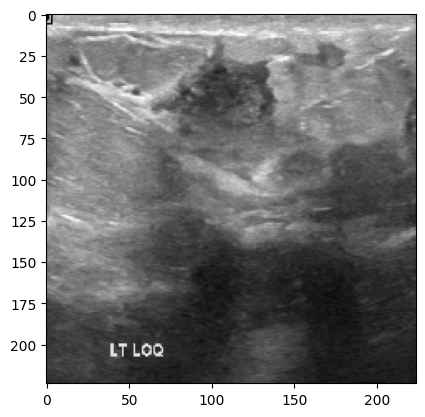

In [118]:
image_name = "test.png"  # Path to the image file
# Load the image and resize it to the target size of 224x224 pixels
img = image.load_img(image_name, target_size=(224, 224))

# Convert the image to a numpy array
x = image.img_to_array(img)

# Display the image
plt.imshow(x/255) # dividing by 255 to display the image correctly

In [119]:
from keras.applications.vgg16 import preprocess_input

In [120]:
z = np.expand_dims(x,axis=0)
img_data = preprocess_input(z)
img_data.shape

model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00, 1.8673619e-23, 7.2895546e-42]], dtype=float32)

In [121]:
result = np.argmax(model.predict(img_data), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [122]:
result

array([0])

In [123]:
if result[0] == 0:
    prediction = "Benign"
    print(prediction)
elif result[0] == 1:
    prediction = "Malignant"
    print(prediction)
else:
    prediction = "Normal"
    print(prediction)

Benign
